In [25]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm

In [26]:
cam0=np.array([[5299.313, 0 ,1263.818] ,
               [0, 5299.313 ,977.763],
                [ 0, 0, 1]])
cam1=np.array([[5299.313, 0, 1438.004],
      [ 0, 5299.313, 977.763],
      [ 0, 0, 1]])
baseline=177.288

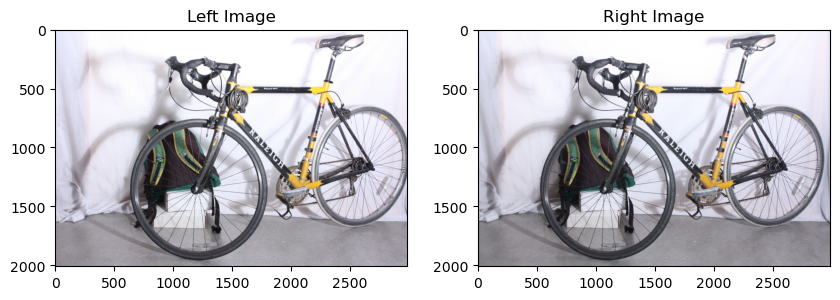

In [27]:
imgl = plt.imread(r'Assignment 1 Input Images\Question 2 and 3 Images\bikeL.png')
imgr = plt.imread(r'Assignment 1 Input Images\Question 2 and 3 Images\bikeR.png')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(imgl)
plt.title('Left Image')
plt.subplot(1,2,2)
plt.imshow(imgr)
plt.title('Right Image')
plt.show()


In [29]:
def normalized_cross_corr(a, b):
    norm_a = np.linalg.norm(a)
    a = a / norm_a
    norm_b = np.linalg.norm(b)
    b = b / norm_b
    return np.correlate(a.ravel(), b.ravel())

def scan_line_correspondence(img_strip,template):
    max_idx = 0
    max_corr = 0
    stride = template.shape[1]
    pad = stride//2
    for ypixel in range(img_strip.shape[1]-stride+1):
        img_patch = img_strip[:, ypixel:ypixel+stride]
        corr = normalized_cross_corr(img_patch, template)
        if corr > max_corr:
            max_idx = ypixel
            max_corr = corr
            if max_corr > 0.95:
                break
    return max_idx

def stero_matching(imgl, imgr, template_size):
    height, width = imgl.shape
    disparity = np.zeros_like(imgl)
    for i in tqdm(range(0,height,template_size[0])):
        slice_x = slice(i,i+template_size[0])
        jr_prev = 0
        for j in range(0,width,template_size[1]):
            template = imgl[slice_x, j:j+template_size[1]]
            img_strip = imgr[slice_x, jr_prev:]
            jr = scan_line_correspondence(img_strip, template)
            disparity[slice_x, j:j+template_size[1]] = j - jr
            jr_prev = jr   
    disparity[disparity ==0] = disparity[disparity != 0].mean()
    return disparity

In [30]:
l_dir = r'Assignment 1 Input Images\Question 2 and 3 Images\bikeL.png'
r_dir = r'Assignment 1 Input Images\Question 2 and 3 Images\bikeR.png'
def read_img(img_dir):
    img = cv.imread(img_dir)
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    return gray

In [31]:
img_l = read_img(l_dir)
img_r = read_img(r_dir)
disparity = stero_matching(img_l, img_r, (7,7))

100%|██████████| 287/287 [00:34<00:00,  8.35it/s]


Text(0.5, 1.0, 'Disparity Map')

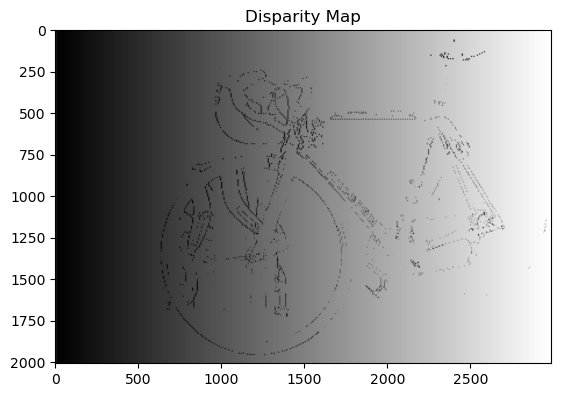

In [42]:
plt.imshow(np.clip(disparity,0,10000),'gray')
plt.title('Disparity Map')

In [33]:
z = baseline * cam0[0,0] / (disparity  + cam1[0,2] - cam0[0,2])

In [35]:
z[0].min(), z[0].max()

(297.67087, 5185.3037)

Text(0.5, 1.0, 'Depth Map')

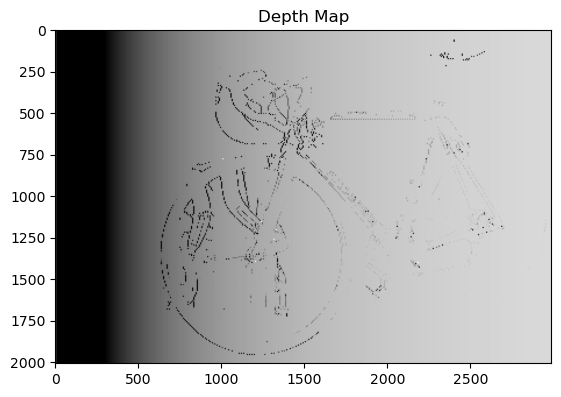

In [49]:
clip = 2000
plt.imshow((clip - np.clip(z,0,clip)),cmap='gray')
plt.title('Depth Map')

In [15]:
x = z* (np.row_stack([np.arange(0, z.shape[1]) - cam0[0,2]]*z.shape[0])) / cam0[0,0]
y = z* (np.column_stack([np.arange(0, z.shape[0]) - cam0[1,2]]*z.shape[1])) / cam0[1,1]